In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


In [2]:

DATA_PATH = Path("/Users/nadaashraf/Heart_Disease_Project/data/heart_selected_features.csv")
assert DATA_PATH.exists(), f"Missing {DATA_PATH}. Run 03_feature_selection first."

df = pd.read_csv(DATA_PATH)
print("Selected-features shape:", df.shape)


Selected-features shape: (920, 14)


In [3]:
X = df.drop(columns=["num"])
y = (df["num"] > 0).astype(int)  # 0=healthy, 1=disease  ✅ binary
print("Class balance:", y.value_counts(normalize=True).rename({0:"healthy",1:"disease"}))

Class balance: num
disease    0.553261
healthy    0.446739
Name: proportion, dtype: float64


In [4]:
from sklearn.utils.class_weight import compute_class_weight


#train test split 80% train and 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)


#defining models (logistic regression, desision tree, random forest, and SVM)
models = {
    "LogisticRegression": LogisticRegression(
        max_iter=1000, solver="liblinear", class_weight="balanced", random_state=42
    ),
    "DecisionTree": DecisionTreeClassifier(
        class_weight="balanced", random_state=42
    ),
    "RandomForest": RandomForestClassifier(
        n_estimators=300, class_weight="balanced", random_state=42
    ),
    "SVM": SVC(
        kernel="rbf", probability=True, class_weight="balanced", random_state=42
    ),
}
list(models.keys())


['LogisticRegression', 'DecisionTree', 'RandomForest', 'SVM']

In [5]:
#training models 
#predicting

rows = []
for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred  = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)[:, 1]

    rows.append([
        name,
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, zero_division=0),
        recall_score(y_test, y_pred, zero_division=0),
        f1_score(y_test, y_pred, zero_division=0),
        roc_auc_score(y_test, y_proba),
    ])

results = pd.DataFrame(rows, columns=["Model","Accuracy","Precision","Recall","F1","ROC_AUC"])
results.sort_values("ROC_AUC", ascending=False)


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,LogisticRegression,0.820652,0.834951,0.843137,0.839024,0.906265
3,SVM,0.826087,0.830189,0.862745,0.846154,0.902439
2,RandomForest,0.836957,0.833333,0.882353,0.857143,0.897238
1,DecisionTree,0.782609,0.792453,0.823529,0.807692,0.777618


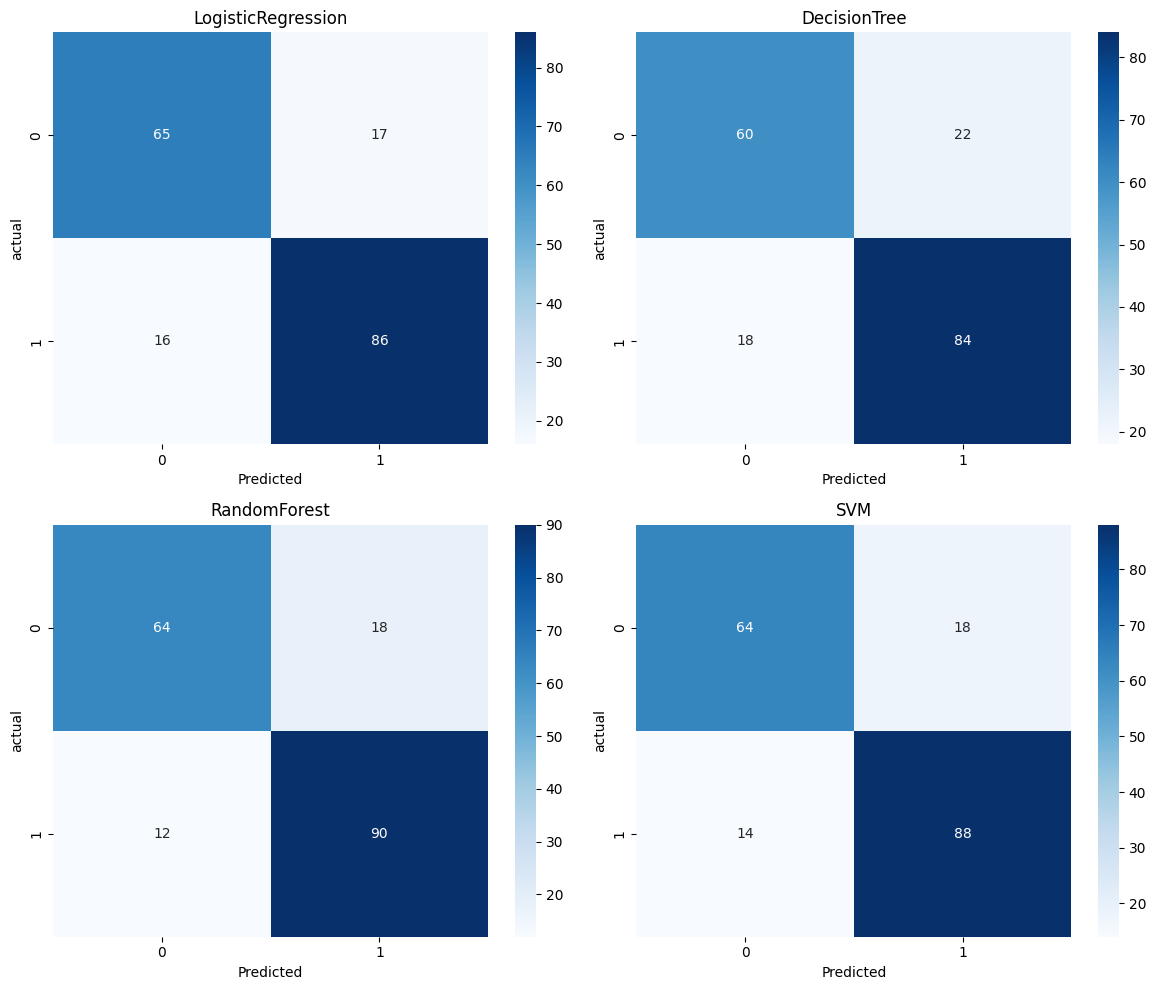

In [7]:
#visualization of results Confusion Matrix

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for ax, (name, clf) in zip(axes, models.items()):
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(f"{name}")
    ax.set_xlabel("Predicted"); ax.set_ylabel("actual")

plt.tight_layout()
plt.show()


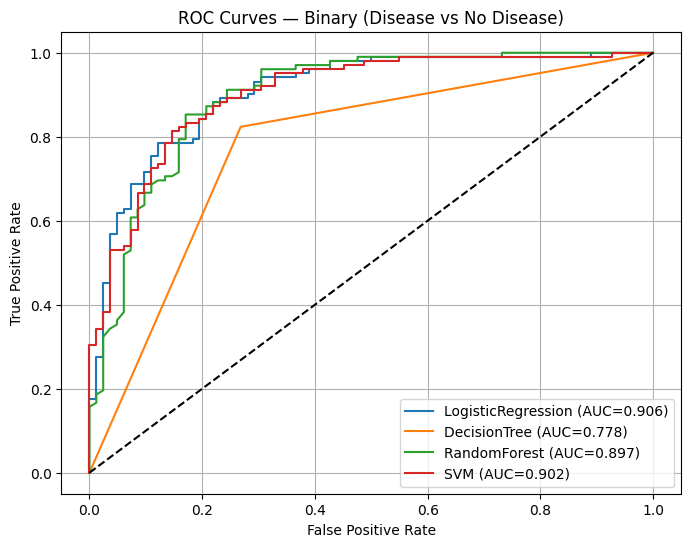

In [9]:

#ROC Curve
plt.figure(figsize=(8,6))
for name, clf in models.items():
    y_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr, tpr):.3f})")
plt.plot([0,1],[0,1],"k--")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Binary (Disease vs No Disease)")
plt.legend()
plt.grid(True)
plt.show()


In [11]:
#classification reports
for name, clf in models.items():
    y_pred = clf.predict(X_test)
    print(f"\n{name} — Classification Report (Binary)")
    print(classification_report(y_test, y_pred, zero_division=0))



LogisticRegression — Classification Report (Binary)
              precision    recall  f1-score   support

           0       0.80      0.79      0.80        82
           1       0.83      0.84      0.84       102

    accuracy                           0.82       184
   macro avg       0.82      0.82      0.82       184
weighted avg       0.82      0.82      0.82       184


DecisionTree — Classification Report (Binary)
              precision    recall  f1-score   support

           0       0.77      0.73      0.75        82
           1       0.79      0.82      0.81       102

    accuracy                           0.78       184
   macro avg       0.78      0.78      0.78       184
weighted avg       0.78      0.78      0.78       184


RandomForest — Classification Report (Binary)
              precision    recall  f1-score   support

           0       0.84      0.78      0.81        82
           1       0.83      0.88      0.86       102

    accuracy                       

In [12]:
#Cross-validation on train set (AUC)

from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_table = []
for name, clf in models.items():
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring="roc_auc")
    cv_table.append([name, scores.mean(), scores.std()])
pd.DataFrame(cv_table, columns=["Model","CV mean AUC","CV std"]).sort_values("CV mean AUC", ascending=False)


,Model,CV mean AUC,CV std
3,SVM,0.884175,0.021033
0,LogisticRegression,0.881876,0.020677
2,RandomForest,0.867800,0.020145
1,DecisionTree,0.712687,0.027585


In [13]:
from pathlib import Path
summary = results.sort_values("ROC_AUC", ascending=False)
out = Path("/Users/nadaashraf/Heart_Disease_Project/results/evaluation_metrics.txt")

with out.open("w") as f:
    f.write(summary.to_string(index=False))
print("Saved summary to:", out.resolve())

summary


Saved summary to: /Users/nadaashraf/Heart_Disease_Project/results/evaluation_metrics.txt


,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,LogisticRegression,0.820652,0.834951,0.843137,0.839024,0.906265
3,SVM,0.826087,0.830189,0.862745,0.846154,0.902439
2,RandomForest,0.836957,0.833333,0.882353,0.857143,0.897238
1,DecisionTree,0.782609,0.792453,0.823529,0.807692,0.777618
